In [31]:
import re
import os
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from tqdm.notebook import tqdm 
from unidecode import unidecode
from datetime import datetime
import requests
import pickle
import numpy as np
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import string
import PyPDF2
from PyPDF2 import PdfFileReader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laubc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laubc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

In [4]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")
with HTMLSession() as sess:
    r = sess.get(url)

In [5]:
def extract_articles(ses):
    """
    Extrae todos los artículos de la página
    """
    r = sess.get(url)
    articles = r.html.find("tr")
    return articles

In [6]:
articles = r.html.find("tr")
len(articles)

184

In [7]:
class_date = "td[class='bmdateview']"
class_title = "td[class='bmtextview']"
all_articles = []

In [8]:
   ### Generación del DF con las columnas: Date, Text, url   ###

for art_id in range(len(articles)):
    date = r.html.find(class_date)[art_id].text
    date = pd.to_datetime(date, format ="%d/%m/%y")
    aux_title = r.html.find(class_title)[art_id]
    title, *_ = re.findall(".*(?=\nTexto)",aux_title.text)
    link,*_ =r.html.find(class_title)[art_id].absolute_links
    all_articles.append([date,title,link])

tabla = pd.DataFrame(all_articles, columns=[ "date","text","url"]).set_index("date")

In [9]:
   ### DF con comunicados anteriores al 15 de febrero de 2008   ###

tabla = tabla.loc[tabla.index > pd.Timestamp(2008,2,15)]


In [10]:
  ### Creando el archivo .pkl   ####
    
tabla.to_pickle("comunicados-banixco.pkl")

In [11]:
  ###  Incluyendo la categoría a los comunicados   ###
    
tabla["category"] = tabla.text.str.extract("(disminuye|incrementa|mantiene)")

In [12]:
   ###  Conteno del movimiento de la tasa   ###

tabla.category.value_counts()

mantiene      71
incrementa    18
disminuye     16
Name: category, dtype: int64

C:\Users\laubc\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


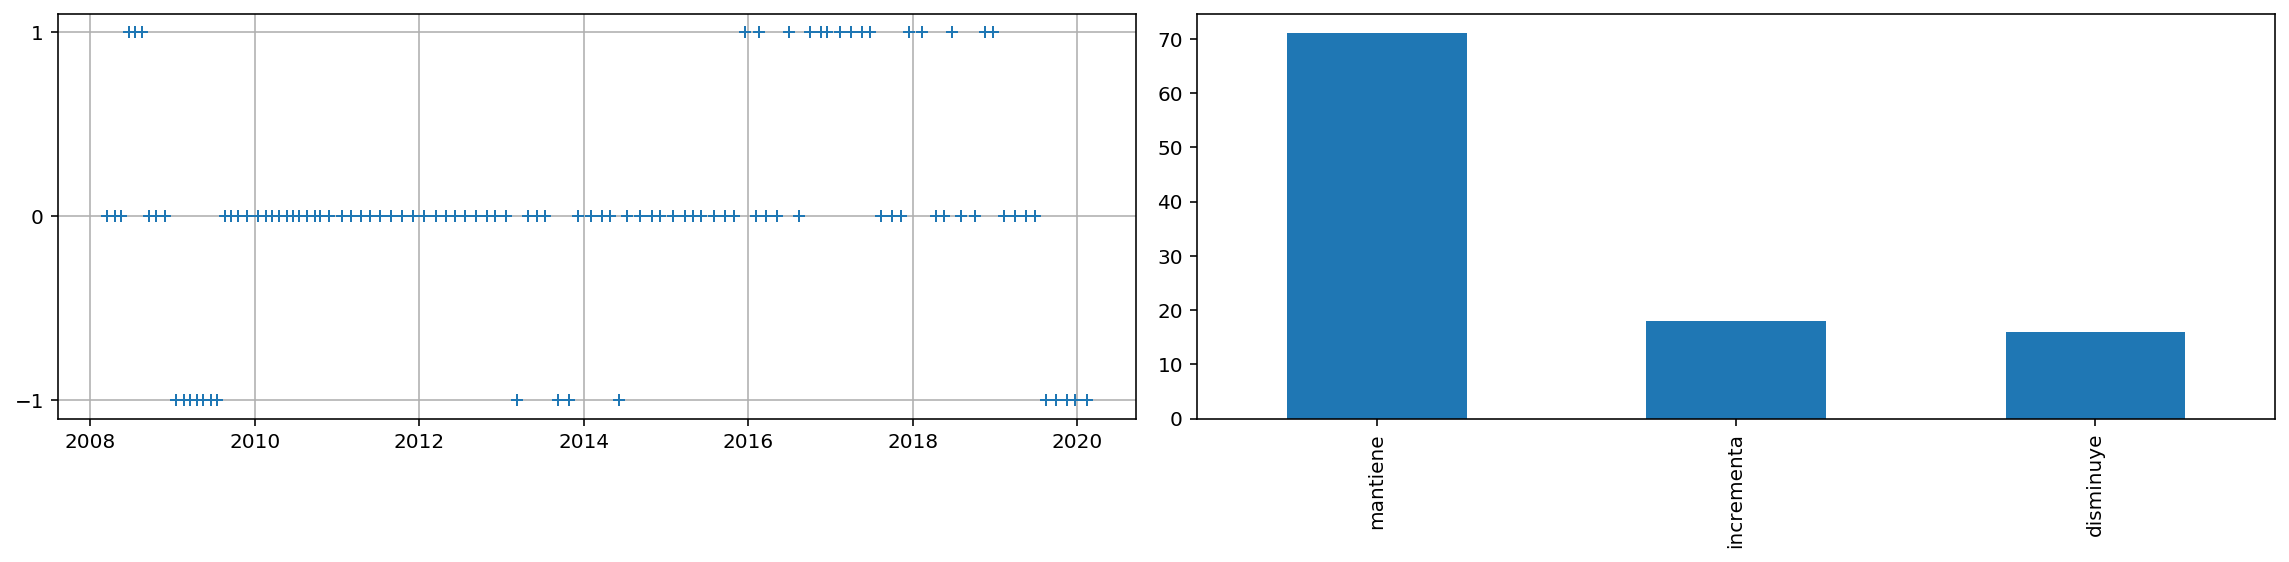

In [13]:
   ### Gráfica sobre los movimientos de las tasas  ###

values = {'mantiene' : 0 , 'incrementa' : 1, 'disminuye' : -1}
table=tabla.category.map(values)

#se generan las dos graficas
fig, axes= plt.subplots(ncols=2, figsize=(16,4))
plt.setp(axes[0], yticks=([1, 0, -1]))
axes[0].grid()
axes[0].plot(table.index,table, '+')
tabla.category.value_counts().plot(kind='bar',ax=axes[1])
fig.tight_layout()   


In [14]:
   ### Agrupación por año y categoría   ###
tabla_resumen= tabla.category.groupby(tabla.index.year).value_counts()
tabla_resumen.head()


date  category  
2008  mantiene       6
      incrementa     3
2009  disminuye      7
      mantiene       4
2010  mantiene      11
Name: category, dtype: int64

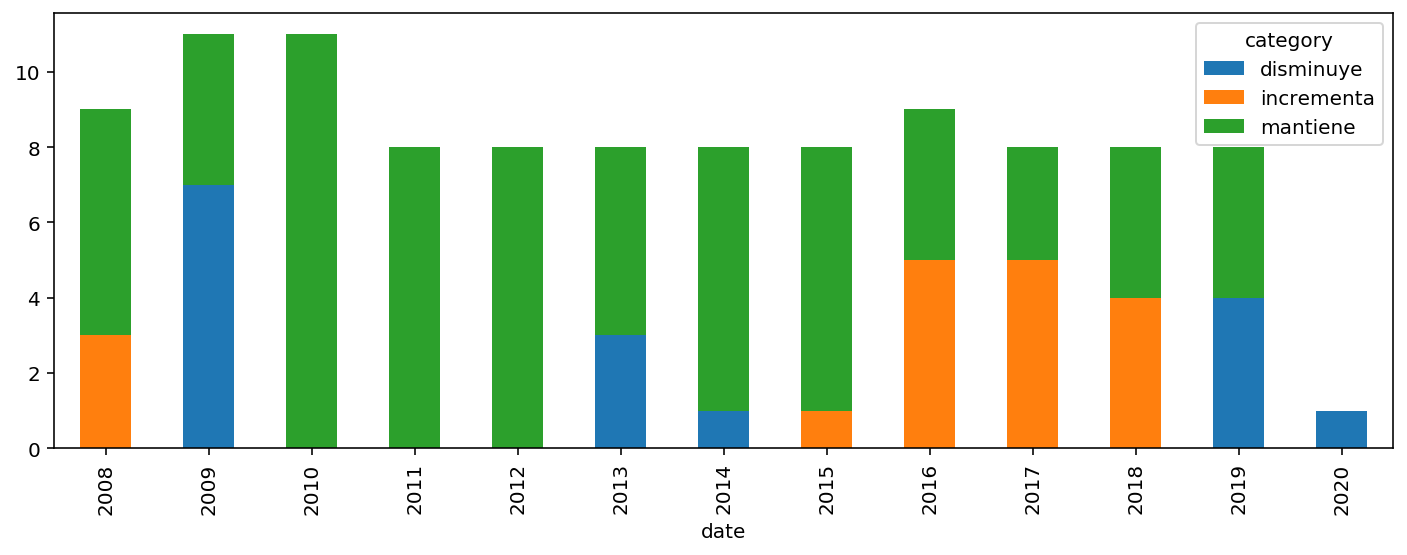

In [15]:
   ### Gráfica de barras de la agrupación anterior   ###
    
tabla_resumen.unstack(level=1).plot.bar(stacked=True)

# Parte 2

In [16]:

###  Descargar pdf  ###
for i in range(0,len(tabla)):
    r_1=requests.get(tabla.url[i],stream = True)
    paper=r_1.content

    fill = str(tabla.category[i])+str(tabla.index[i]).replace(":", "-")
    
    path=os.path.join("pdf",fill + ".pdf")
    with open(path,"wb") as f:
        f.write(paper)

In [21]:

incrementa=[]
disminuye=[]
mantiene=[]
for j in range(0,len(tabla)):
    fill = str(tabla.category[j])+str(tabla.index[j]).replace(":", "-")
    document = "C:/Users/laubc/Downloads/data-science 220220/data-science-master/ejercicios/pdf/"+fill+".pdf"
    
    with open(document, "rb") as file:  
        pdf = PdfFileReader(file)
        text=""
        for p in range(0,pdf.getNumPages()):
            text += pdf.getPage(p).extractText() + "\n"
            text = " ".join(text.replace("\n", "").strip().split())
            text = " ".join(word.strip(string.punctuation) for word in text.split() if word.isalpha())
    
       
    if fill[:10]=="incrementa":
        incrementa.append(text) 
    elif fill[:9]=="disminuye":
        disminuye.append(text) 
    elif fill[:8]=="mantiene":
        mantiene.append(text)  


diccionario={"incrementa":incrementa,"disminuye":disminuye,"mantiene":mantiene}



In [22]:
k1, k2,k3 = "mantiene", "incrementa","disminuye"

In [23]:


def limpia_dialogo(doc):
    limpio=doc.lower()
    limpio=re.sub(" [^\w ]"," ",limpio)
    return limpio

In [28]:

D1 = [limpia_dialogo(doc) for doc in diccionario[k1]]
D2 = [limpia_dialogo(doc) for doc in diccionario[k2]]
D3 = [limpia_dialogo(doc) for doc in diccionario[k3]]


D1, D1_test = train_test_split(D1, test_size=0.2)
D2, D2_test = train_test_split(D2, test_size=0.2)
D3, D3_test = train_test_split(D3, test_size=0.2)


N1 = len(D1)
N2= len(D2)
N3=len(D3)
N= N1+N2+N3

In [32]:

stopwords = corpus.stopwords.words("spanish")
stopwords = [unidecode(word) for word in stopwords]
stopwords.extend(["mantiene", "incrementa","disminuye"])

In [33]:

V1 = [palabra for dialogo in D1 for palabra in dialogo.split()
      if palabra not in stopwords]

V2 = [palabra for dialogo in D2 for palabra in dialogo.split()
      if palabra not in stopwords]

V3 = [palabra for dialogo in D3 for palabra in dialogo.split()
      if palabra not in stopwords]


V = set(V1) | set(V2) | set(V3)

vocab = pd.DataFrame(index=V)

V1_c = pd.Series(V1, name="k1").value_counts()
V2_c = pd.Series(V2, name="k2").value_counts()
V3_c = pd.Series(V3, name="k3").value_counts()



L = (vocab.join(V1_c, how="left")
          .join(V2_c, how="left")
          .join(V3_c, how="left"))

L = L.fillna(0) + 1
L = L / L.sum(axis=0)
L.sample(10, random_state=314)

,k1,k2,k3
inclusive,0.000117,0.000297,0.000139
nivel,0.002464,0.003460,0.004590
escenarios,0.000313,0.000198,0.000139
mencionadas,0.000156,0.000099,0.000278
negativamente,0.000117,0.000099,0.000417
temporales,0.000117,0.000494,0.000139
lugar,0.001604,0.000593,0.000695
provocar,0.000078,0.000099,0.000417
prácticamente,0.000469,0.000791,0.000278
reflejo,0.001017,0.000890,0.000417


In [34]:

log_L = np.log(L)

log_prior_k1 = np.log(N1 / N)
log_prior_k2 = np.log(N2 / N)
log_prior_k3 = np.log(N3 / N)


log_priors = np.array([log_prior_k1, log_prior_k2,log_prior_k3])

In [35]:

print("Valores del conjunto de prueba: ",  "\nMantiene: ",  len(D1_test) , "\nIncrementa: " ,len(D2_test),"\nDisminuye: " ,len(D3_test))

Valores del conjunto de prueba:  
Mantiene:  15 
Incrementa:  4 
Disminuye:  4


In [36]:


D_test = D1_test + D2_test+D3_test
y_test = ["k1"] * len(D1_test) + ["k2"] * len(D2_test) + ["k3"] * len(D3_test)


yhat_test = []

for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    yhat_test.append(res.idxmax())

In [37]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_test)

array([[13,  1,  1],
       [ 0,  4,  0],
       [ 1,  0,  3]], dtype=int64)